<img src="images/dask_horizontal.svg" align="center" width="30%">

# Parallelize code with `dask.delayed`



In this section we parallelize simple for-loop style code with Dask and `dask.delayed`. Often, this is the only function that you will need to convert functions for use with Dask.

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](https://blog.dask.org/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.


## Learning Objectives 

- Deploy a local Dask Distributed Cluster and access the diagnostics dashboard
- Work with `dask.delayed` to parallelize custom functions/workloads

## Prerequisites


| Concepts | Importance | Notes |
| --- | --- | --- |
| Familiarity with Python | Necessary | |
| Familiarity with xarray | Helpful | |


- **Time to learn**: *25-35 minutes*

## Imports

In [4]:
import time

import dask
from dask.distributed import Client, LocalCluster

## Deploy a local Dask Distributed Cluster

As we'll see in the [distributed scheduler notebook](11-dask-distributed.ipynb), Dask has several ways of executing code in parallel. We'll use the distributed scheduler by creating a `dask.distributed.LocalCluster` and then passing that to the `dask.distributed.Client`. For now, this will provide us with some nice diagnostics. We'll talk about schedulers in depth later.

In [3]:
cluster = LocalCluster()
client = Client(cluster)
client

/Users/mgrover/anaconda3/envs/pythia-book-dev/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51021 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:51021/status,
Dashboard: http://127.0.0.1:51021/status,Workers: 4
Total threads: 16,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51022,Workers: 4
Dashboard: http://127.0.0.1:51021/status,Total threads: 16
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://10.2.2.56:51034,Total threads: 4
Dashboard: http://10.2.2.56:51035/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:51025,


**Review from the Dask Overview**:

- A cluster is a set of "workers". In the `LocalCluster` case, these workers are all on a single machine
- A client allows us to connect our jupyter notebook or script to the cluster

## Basics

First let's make some toy functions, `square`, `add`, and `square_root` that sleep for a while to simulate work. We'll then time running these functions normally.

In the next section we'll parallelize this code.

In [5]:
def square(x):
    time.sleep(1)
    return x ** 2


def add(x, y):
    time.sleep(1)
    return x + y


def square_root(x):
    time.sleep(1)
    return x ** (1 / 2)

We time the execution of this normal code using the `%%time` magic, which is a special function of the Jupyter Notebook.

In [6]:
%%time

x = square(3)
y = square(4)
z = add(x, y)
r = square_root(z)
r

CPU times: user 149 ms, sys: 33.3 ms, total: 182 ms
Wall time: 4.02 s


5.0

This takes `~4 seconds` to run because we call each function sequentially, one after the other.

Those two `square` calls *could* be called in parallel, because they are totally independent of one-another.

We'll transform the `square`, `add`, and `square_root` functions using the `dask.delayed` function. When we call the delayed version by passing the arguments, exactly as before, the original function isn't actually called yet - which is why the cell execution finishes very quickly.
Instead, a *delayed object* is made, which keeps track of the function to call and the arguments to pass to it.


In [7]:
%%time
delayed_square = dask.delayed(square)
delayed_add = dask.delayed(add)
delayed_square_root = dask.delayed(square_root)

x = delayed_square(3)
y = delayed_square(4)
z = delayed_add(x, y)
r = delayed_square_root(z)
r

CPU times: user 417 µs, sys: 109 µs, total: 526 µs
Wall time: 505 µs


Delayed('square_root-8b1a8ce3-e992-4db9-a478-40ced7f3b3ec')

**This ran immediately, since nothing has really happened yet.** 

To get the result, call `compute`. 

In [8]:
%%time

r.compute()

CPU times: user 200 ms, sys: 84.6 ms, total: 285 ms
Wall time: 3.16 s


5.0



<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold"></p>
    Notice that this runs faster than the original code.
</div>

## What just happened?

The `r` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another.  We can evaluate the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

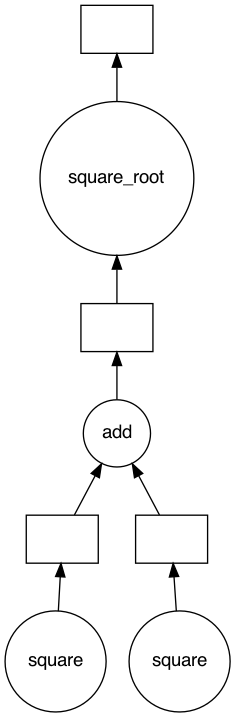

In [9]:
r.visualize()

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Reminder: Task and Task Graphs</p>
    <ul>
        <li> A task is a function that you want to call and its corresponding inputs. </li>
    <li> A task graph is a collection of (1) the functions we want to call + their inputs (2) their dependencies. </li>
    </ul>
</div>


<img src="images/dask-task-stream.gif">




By default the task graph is rendered from top to bottom. In the case that you prefer to visualize it from left to right, pass `rankdir="LR"` as a keyword argument to `.visualize()`.

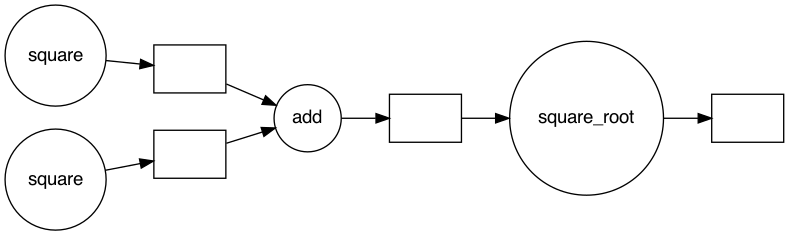

In [10]:
r.visualize(rankdir="LR")

Notice that this includes the names of the functions from before, and the logical flow of the outputs of the `square` functions to the inputs of `add` and `square_root`.

### Some questions to consider:

-  Why did we go from 4s to 3s?  Why weren't we able to parallelize down to 2s?
-  What would have happened if the `square`, `add`, and `square_root` functions didn't include the `sleep(1)`?  Would Dask still be able to speed up this code?
-  What if we have multiple outputs or also want to get access to x or y?

## Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` on our custom `square` function and the built-in `sum`  function to parallelize the computation below:

In [11]:
data = list(range(1, 11))
data

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [12]:
%%time
results = []
for x in data:
    y = square(x)
    results.append(y)

total = sum(results)

CPU times: user 432 ms, sys: 95.1 ms, total: 527 ms
Wall time: 10 s


Instead of using the for loop from above, we can add in `dask.delayed` to ***lazily*** complete this task. Notice how much faster this solution is (10 seconds vs. 1 second)!

In [14]:
%%time

results = []

for x in data:
    y = delayed_square(x)
    results.append(y)

total = dask.delayed(sum)(results)
print(f"Before computing: {total}")  # Let's see what type of thing total is

result = total.compute()
print(f"After computing : {result}", result)  # After it's computed

Before computing: Delayed('sum-078ab591-b13a-468a-8be7-fc154db20a81')
After computing : 385 385
CPU times: user 67.6 ms, sys: 14.6 ms, total: 82.2 ms
Wall time: 1.03 s


How do the graph visualizations compare with the given solution, compared to a version with the `sum` function used directly rather than wrapped with `delayed`? Can you explain the latter version? You might find the result of the following expression illuminating


```python

delayed_square(1) + delayed_square(2)
```

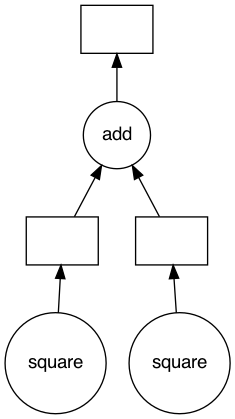

In [15]:
z = delayed_square(1) + delayed_square(2)
z.visualize()

You'll notice ***how long*** this task graph is, leading to a longer compute time since everything is done **sequentially** instead of **in parallel**

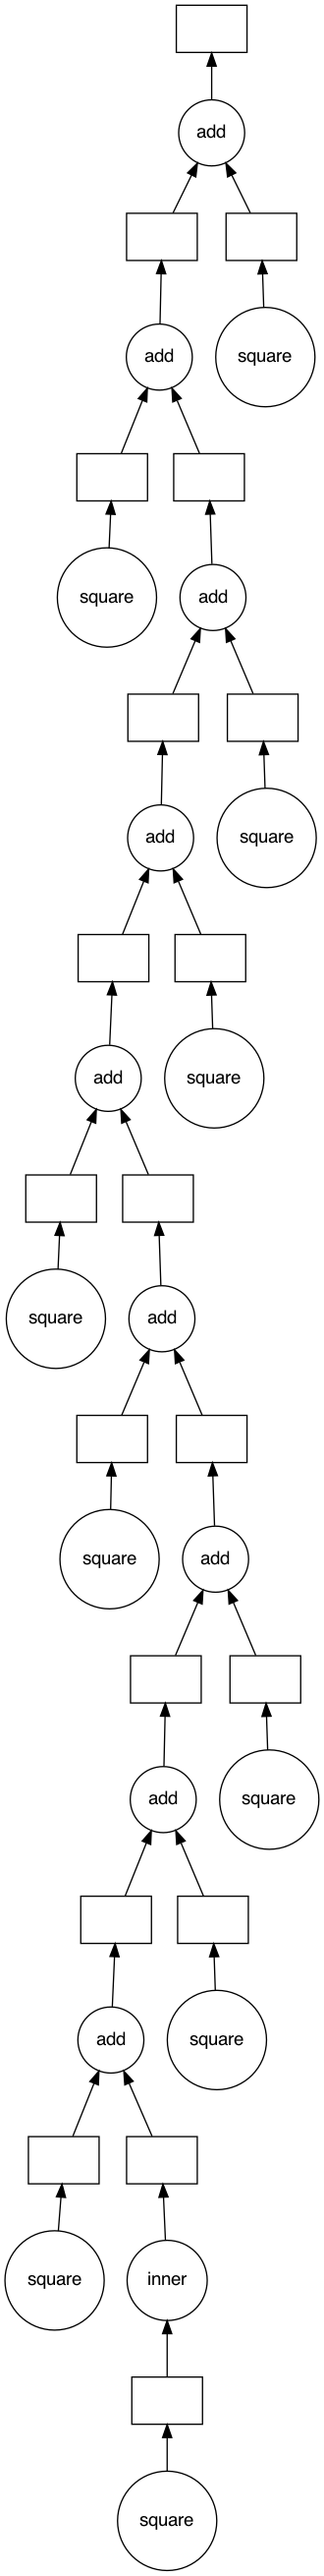

In [16]:
sum(results).visualize()

Our total (`dask.delayed(sum)(results)`), utilizes `dask.delayed` to complete tasks **in parallel**, which leads to a **wider** task graph, with more tasks occurring at the same time, aggregating in the end.

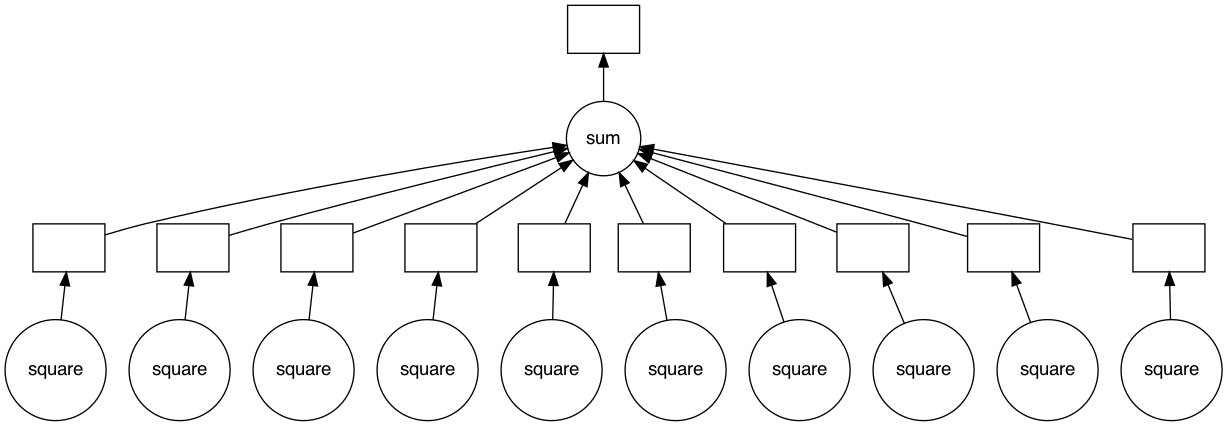

In [18]:
total.visualize()

## Exercise: Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `square`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `square` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [19]:
def double(x):
    time.sleep(1)
    return x * 2


def square(x):
    time.sleep(1)
    return x ** 2


def is_even(x):
    return not x % 2


data = list(range(1, 11))
data

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Below is our sequential code; utilizing a for loop with conditional checks

In [22]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = square(x)
    results.append(y)

total = sum(results)
print(total)

225
CPU times: user 441 ms, sys: 94 ms, total: 535 ms
Wall time: 10 s


Again, we can add in `dask.delayed` here to speed things up - but be careful! `Dask.delayed` cannot deal with booleans (True/False)...

In [26]:
results = []
for x in data:
    if dask.delayed(is_even)(x):  # even
        y = dask.delayed(double)(x)
    else:  # odd
        y = dask.delayed(square)(x)
    results.append(y)

total = dask.delayed(sum)(results)
total.visualize()

TypeError: Truth of Delayed objects is not supported

Instead, we can keep the delayed out of the `if` line, while still lazily doubling or squaring the value within the `if` block, preventing us from having a delayed Boolean

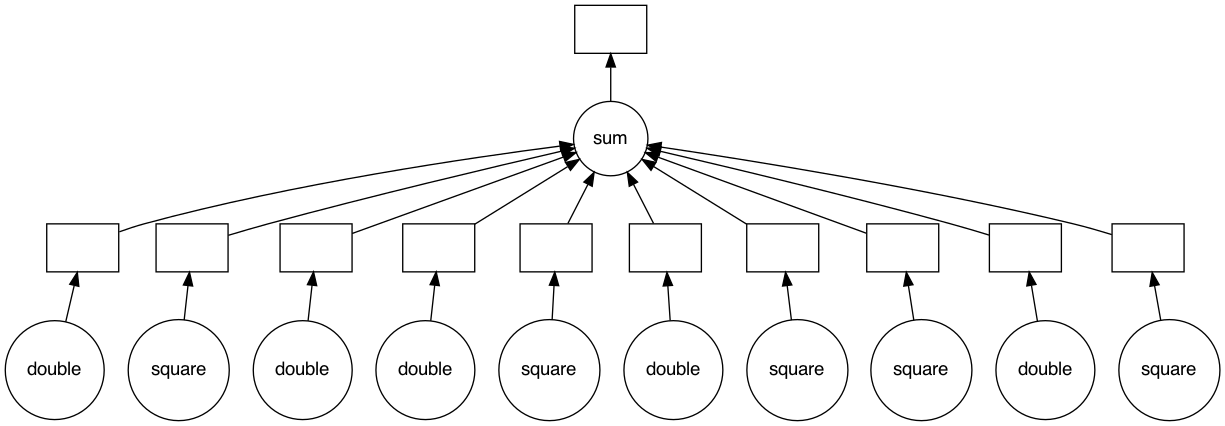

In [27]:
results = []
for x in data:
    if is_even(x):  # even
        y = dask.delayed(double)(x)
    else:  # odd
        y = dask.delayed(square)(x)
    results.append(y)

total = dask.delayed(sum)(results)
total.visualize()

We see that we are **still computing this in parallel**, with improved performance.

In [28]:
%%time
total.compute()

CPU times: user 55.1 ms, sys: 13.6 ms, total: 68.7 ms
Wall time: 1.03 s


225

## Close the Cluster and Client

Before moving on to the next notebook, make sure to close your cluster, and client or stop this kernel.

In [29]:
client.close()
cluster.close()

---

## Summary

- `dask.delayed` is a handy mechanism for creating the Dask graph, but the adventurous may wish to play with the full fexibility afforded by building the graph dictionaries directly. Detailed information can be found [here](https://dask.pydata.org/en/latest/graphs.html).

## Learn More

Visit the [Delayed documentation](https://docs.dask.org/en/latest/delayed.html). In particular, this [delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU) will reinforce the concepts you learned here and the [delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html) document collects advice on using `dask.delayed` well.

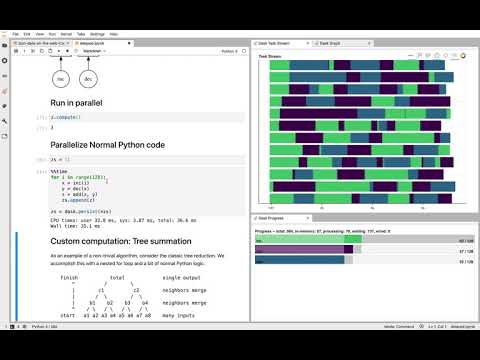

In [31]:
from IPython.display import YouTubeVideo

YouTubeVideo(id="SHqFmynRxVU", width=600, height=300)

## Resources and references

* Reference
    *  [Docs](https://dask.org/)
    *  [Examples](https://examples.dask.org/)
    *  [Code](https://github.com/dask/dask/)
    *  [Blog](https://blog.dask.org/)
*  Ask for help
    *   [`dask`](http://stackoverflow.com/questions/tagged/dask) tag on Stack Overflow, for usage questions
    *   [github discussions](https://github.com/dask/dask/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues](https://github.com/dask/dask/issues/new) for bug reports and feature requests
    
* Pieces of this notebook are adapted from the following sources
  * https://github.com/dask/dask-tutorial/blob/main/01_dask.delayed.ipynb